# MC versus Data Histogram

In [1]:
import numpy as np
import pandas as pd
import collections
import gzip
import os
import time
import array
import pickle
import ROOT
import matplotlib
import matplotlib.pyplot as plt
import rootplotlib as rpl
from pprint import pprint
from ROOT import kBird,kBlackBody,kTRUE
from ROOT import TCanvas, gStyle, TLegend, gPad, TLatex, TEnv, gROOT, TLine, TColor
from ROOT import kAzure, kRed, kBlue, kBlack,kBird, kOrange,kGray
from ROOT import TGraphErrors,TF1,TH1F,TH2F
rpl.set_atlas_style()
rpl.suppress_root_warnings()
os.makedirs("output",exist_ok=True)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Module libc not found.


Welcome to JupyROOT 6.26/10

Applying ATLAS style settings...


In [2]:
etbins     = [15, 20, 30, 40, 50, 1000000]
etabins    = [0.0, 0.8, 1.37, 1.54, 2.37, 2.50]
references = ['tight_cutbased', 'medium_cutbased' , 'loose_cutbased', 'vloose_cutbased']
model_path = '/mnt/cern_data/joao.pinto/tunings/releases/Run2_20170505_v6/models'
model_path+='/mc15_13TeV.361106_Zee.423300_perf_JF17.25bins.ElectronVeryLoose.Run2_v6.et{ET}_eta{ETA}.h5'

In [3]:
def read_data( file_name ):
    d = dict(np.load(file_name))
    features = d['features'].tolist()
    target = d['target']
    data = d['data']
    data_df = pd.DataFrame({name:data[:,idx] for idx,name in enumerate(features)})
    data_df["target"] = target
    return data_df

def get_data( path ):
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    d = read_data(path)
    feature_names = d['features'].tolist()
    # How many events?
    n = d['data'].shape[0]
    # extract rings
    data_rings = norm1(d['data'][:,1:101])
    target = d['target']
    avgmu = d['data'][:,0]
    return [data_rings], target, avgmu

def get_model( file_name, remove_last=True):
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Activation
    path=file_name.format(ET=et_bin+3,ETA=3 if eta_bin==4 else eta_bin)
    model = tf.keras.models.load_model(file_name)
    model.add(Activation('tanh'))
    new_model = Model(model.inputs, model.layers[-2].output) if remove_last else model                
    # return the models's matrix          
    return new_model

def predict( data, model, col_name ):
    ring_names = [f"L2Calo_ring_{idx}" for idx in range(100)]
    rings = data[ring_names].values
    print(rings.shape)
    def norm1( data ):
        norms = np.abs( data.sum(axis=1) )
        norms[norms==0] = 1
        return data/norms[:,None]
    rings = norm1(rings)
    output = model.predict(rings)
    data[col_name] = output

In [4]:
et_bin = 5
eta_bin = 0
data_basepath = '/mnt/cern_data/joao.pinto'
data16_file_name = f"{data_basepath}/files/data16_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.GRL_v97.mc15_13TeV.bkg.Truth.JF17/data16_13TeV.AllPeriods.sgn.probes_lhmedium.GRL_v97.mc15_13TeV.bkg.Truth.JF17_et{et_bin-3}_eta{eta_bin}.npz"
data16 = read_data(data16_file_name)

In [5]:
et_bin = 5
eta_bin = 0
data_basepath = '/mnt/cern_data/joao.pinto'
mc15_file_name = f"{data_basepath}/files/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17_et{et_bin-3}_eta{eta_bin}.npz"
mc15 = read_data(mc15_file_name)

In [6]:
et_bin = 5
eta_bin = 0
model_path = f"{data_basepath}/tunings/releases/Run2_20170505_v6/models/mc15_13TeV.361106_Zee.423300_perf_JF17.25bins.ElectronVeryLoose.Run2_v6.et{et_bin}_eta{eta_bin}.h5"
model = get_model(model_path)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 dense_136 (Dense)           (None, 7)                 707       
                                                                 
 dense_137 (Dense)           (None, 1)                 8         
                                                                 
Total params: 715 (2.79 KB)
Trainable params: 715 (2.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-09-27 19:14:07.406323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 19:14:12.939159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-27 19:14:21.359143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)
2024-09-27 19:14:21.359165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: caloba70
2024-09-27 19:14:21.359168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: caloba70
2024-09-27 19:14:21.359253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable

In [7]:
predict( data16, model, "output")
data16.head()

(1182602, 100)
36957/36957 [==============================] - 18s 474us/step


,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,el_lhtight,el_lhmedium,el_lhloose,el_lhvloose,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,target,output
0,16.139999,974.264038,32.916992,-202.457382,133.409378,-59.745018,161.094116,-10.020514,-84.597466,1820.945679,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,1.849686
1,16.139999,1107.130493,643.721191,898.925415,63.031670,-250.598160,3.458161,-9.123405,197.430695,3204.726318,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,1.961232
2,16.139999,1020.475220,601.927368,61.061958,-102.277756,-45.705685,588.079529,-49.082920,36.417133,4532.319336,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,3.538005
3,16.139999,424.455353,416.694550,442.753723,30.866570,-12.334311,-219.258621,-13.294891,-30.208305,3476.415771,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,2.783234
4,16.139999,187.521774,336.321045,-3.008097,-52.800140,-162.948853,-96.902473,93.093903,-117.904236,1720.804321,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,2.678447


In [8]:
predict( mc15, model, "output")
mc15.head()

(121879, 100)
3809/3809 [==============================] - 2s 479us/step


,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,el_lhtight,el_lhmedium,el_lhloose,el_lhvloose,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,target,output
0,36.0,767.492859,-0.472072,-361.322906,-566.061462,-44.995815,-290.825470,-330.343048,82.031937,4338.279785,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,5.677966
1,35.0,3193.005615,507.466522,-117.344635,123.058914,-466.772736,-199.998657,-227.583694,-305.141785,4564.270020,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,4.652092
2,32.0,1242.509766,235.931381,-946.631104,-163.778656,-293.556519,121.769760,402.875458,151.547943,4666.197266,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,1.872264
3,32.0,1177.818115,1213.914551,280.930267,56.904209,224.553268,-195.941803,223.152023,-188.977600,3581.760254,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,1.922277
4,31.0,1174.903687,463.270630,270.546570,425.828461,-365.683044,-49.664135,41.832600,196.151901,3409.914062,...,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,1,1.521122


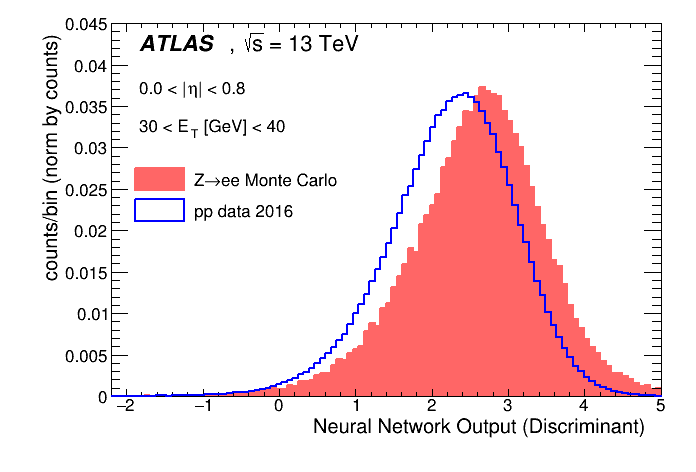

In [9]:

xbins = 100
xmin  = -2.2
xmax  = 5.0
drawopt = "hist,same"

fig = rpl.create_canvas("canvas", "", 700, 500)
rpl.set_figure(fig)

mc_outputs = mc15.loc[mc15.target==1].output.values
data_outputs = data16.loc[data16.target==1].output.values
mc = TH1F( 'mc', '', xbins, xmin, xmax )
w = array.array( 'd', np.ones_like( mc_outputs ) )
mc.FillN( len(mc_outputs), array.array('d',  mc_outputs.tolist()), w)  
pp = TH1F( 'data', '', xbins, xmin, xmax )
w = array.array( 'd', np.ones_like( data_outputs ) )
pp.FillN( len(data_outputs), array.array('d',  data_outputs.tolist()), w)
mc = rpl.hist1d.density(mc)
pp = rpl.hist1d.density(pp)
mc.SetFillColor(kRed-7)
mc.SetLineColor(kRed-7)
pp.SetLineColor(kBlue)
pp.SetLineWidth(2)
mc.Draw(drawopt)
pp.Draw(drawopt)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.05, textfont=72)
rpl.add_text( 0.33, 0.89, ', #sqrt{s} = 13 TeV'   , textsize=0.05)
rpl.add_text(0.2, 0.8, '0.0 < |#eta| < 0.8', textsize=0.04)
rpl.add_text(0.2,  0.72, '30 < E_{T} [GeV] < 40', textsize=0.04)

legends = ['Z#rightarrowee Monte Carlo', 'pp data 2016']
def add_legend(x,y,legends,textsize):
    rpl.add_legend( legends,x,y,x+0.98,y+0.20,textsize=18, option='F')
add_legend( 0.18,0.52, legends,20)
    
rpl.format_canvas_axes(XLabelSize=18, YLabelSize=18, XTitleOffset=0.87, YTitleOffset=1.7)
fig.set_ylabel("counts/bin (norm by counts)")
fig.set_xlabel('Neural Network Output (Discriminant)')
rpl.set_yaxis_ranges(0, 0.045) #, pad='pad_top')
fig.show()
fig.savefig("output/nn_output_mc15_versus_data16_et2_eta0.pdf")
    

